In [1]:
import os
from google.colab import drive  # Google Drive support
drive.mount('/content/drive', force_remount=True)   # Mount Google Drive

Mounted at /content/drive


# Install Dependencies

In [ ]:
!pip install torch torchvision
!pip install -q scikit-learn tqdm matplotlib
!pip install opencv-python

# Imports

In [3]:
import tqdm
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
from tqdm.notebook import tqdm  # For progress bar

# Download Dataset
Download from Kaggle and store my Google Drive

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# Clone data from Kaggle
!mkdir -p /content/drive/My\ Drive/COS30082/Project
!kaggle competitions download -c 11-785-fall-20-homework-2-part-2 -p "/content/drive/My Drive/COS30082/Project/"
print("Data Downloaded")
# Unzip on Colab session
!unzip -q "/content/drive/My Drive/COS30082/Project/11-785-fall-20-homework-2-part-2.zip" -d "/content/face_dataset"
print("Data unzipped to local Colab")
# Move only processed files back to Drive
!cp -r /content/face_dataset "/content/drive/My Drive/COS30082/Project/"
print("Data moved back to Drive")

# Path

In [16]:
DATASET_DIR = "/content/drive/My Drive/COS30082/Project/face_dataset/classification_data"
MODEL_SAVE_PATH = '/content/drive/My Drive/COS30082/Project/models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Paths for each model
supervised_model_path = os.path.join(MODEL_SAVE_PATH, 'classifier/cls_model.pth')
triplet_model_path = os.path.join(MODEL_SAVE_PATH, 'triloss/tri_model.pth')

# Train and val sets
train_path = f"{DATASET_DIR}/train_data"
val_path = f"{DATASET_DIR}/val_data"
PAIR_TXT = f"/content/drive/My Drive/COS30082/Project/face_dataset/verification_pairs_val.txt"

# 1. Data Preparation

In [18]:
class Data(Dataset):
    def __init__(self, root, transform=None, load_all=False):
        """
        Face dataset for classification tasks. Assumes directory structure:
        root/
            ├── label1/
            │    ├── img1
            │    └── img2.jpg
            ├── label2/
            │    ├── img3.jpg
            │    └── img4.jpg
            ...
        Args:
            root (str): Root directory containing labeled subfolders.
            transform (callable): Optional transform to be applied on images.
            load_all (bool): If True, preloads all images into memory.
        """
        self.root = root
        self.transform = transform
        self.unique_label_ids = os.listdir(self.root)
        self.num_classes = len(self.unique_label_ids)
        self.unique_label_nums = list(range(self.num_classes))

        print(f"[INFO] Found {self.num_classes} unique identities.")

        # Initialize storage lists
        self.image_paths = []
        self.label_ids = []
        self.label_nums = []

        # Load image paths and labels
        for label_num, label_id in enumerate(self.unique_label_ids):
            folder_path = os.path.join(self.root, label_id)
            image_files = os.listdir(folder_path)
            full_paths = [os.path.join(folder_path, img) for img in image_files]

            self.image_paths.extend(full_paths)
            self.label_ids.extend([label_id] * len(full_paths))
            self.label_nums.extend([label_num] * len(full_paths))

        assert len(self.image_paths) == len(self.label_nums), "[ERROR] Mismatched image and label count"
        self.data_len = len(self.label_nums)
        print(f"[INFO] Dataset initialized with {self.data_len} total samples.")

        # Preload all images (for runtime usage)
        self.images = dict()
        if load_all:
            print("[INFO] Preloading all images into memory...")
            for i in tqdm(range(self.data_len)):
                self.images[i] = self.__load_image(i)

    def __load_image(self, index):
        """Function to load and transform an image at a given index."""
        image_path = self.image_paths[index]
        img = Image.open(image_path).convert('RGB')  # Force RGB format
        return self.transform(img) if self.transform else img

    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        """Returns (image_tensor, label)"""
        # Lazy loading unless preloaded
        if index in self.images:
            img = self.images[index]
        else:
            img = self.__load_image(index)
        return img, self.label_nums[index]

    def reduce_samples(self, ids):
        """
        Reduces the dataset to only include samples from a subset of label IDs.
        Useful for few-shot or class-specific experiments.
        Args:
            ids (List[str]): Subset of label folder names to keep.
        """
        initial_len = self.data_len
        new_image_paths = []
        new_label_ids = []
        new_label_nums = []

        for i in range(initial_len):
            if self.label_ids[i] in ids:
                new_label_ids.append(self.label_ids[i])
                new_image_paths.append(self.image_paths[i])
                new_label_nums.append(ids.index(self.label_ids[i]))  # Remap label

        # Update dataset
        self.label_ids = new_label_ids
        self.label_nums = new_label_nums
        self.unique_label_ids = ids
        self.num_classes = len(ids)
        self.unique_label_nums = list(range(self.num_classes))
        self.image_paths = new_image_paths
        self.images = dict()  # Reset cache
        self.data_len = len(new_label_ids)

        print(f"[INFO] Reduced dataset:")
        print(f"  Before: {initial_len} samples")
        print(f"  After:  {self.data_len} samples")
        print(f"  Remaining classes: {self.num_classes}")


## **a. Image Transformation**

In [6]:

from torchvision import transforms

params = dict(
    epochs=20,
    batch_size=128,
    num_labels=500, # Use only 500 classes to reduce train time.
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.SGD,
    optimizer_params=dict(
        lr=0.01,
    )
)

CHANNELS = 3 # RGB

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## **b. Load Data**

In [7]:
from torch.utils import data

print("========== [TRAINING DATASET] ==========")
train_dataset = Data(train_path, transform=transform)

# Limit to a subset of labels if specified
labels = train_dataset.unique_label_ids[:params['num_labels']]
train_dataset.reduce_samples(labels)

print("\n========== [VALIDATION DATASET] ==========")
val_dataset = Data(val_path, transform=transform)
val_dataset.reduce_samples(labels)

# DataLoader arguments (shuffle and batch size)
train_loader_args = {
    "shuffle": True,
    "batch_size": params["batch_size"],
}

# Create DataLoaders
train_loader = data.DataLoader(train_dataset, **train_loader_args)
val_loader = data.DataLoader(val_dataset, **train_loader_args)

# Number of classes to pass to the model
NUM_CLASSES = train_dataset.num_classes

print(f"\n[INFO] Final training set size: {len(train_dataset)} samples")
print(f"[INFO] Final validation set size: {len(val_dataset)} samples")
print(f"[INFO] Number of classes: {NUM_CLASSES}")

========== [TRAINING DATASET] ==========
[INFO] Found 4000 unique identities.
[INFO] Dataset initialized with 380638 total samples.
[INFO] Reduced dataset:
  Before: 380638 samples
  After:  48421 samples
  Remaining classes: 500

========== [VALIDATION DATASET] ==========
[INFO] Found 4000 unique identities.
[INFO] Dataset initialized with 8000 total samples.
[INFO] Reduced dataset:
  Before: 8000 samples
  After:  1000 samples
  Remaining classes: 500

[INFO] Final training set size: 48421 samples
[INFO] Final validation set size: 1000 samples
[INFO] Number of classes: 500


# 2. Model Building

## **Imports**

In [8]:

# === Extension: model, training loops, progress bars, and evaluation ===
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


## **a. Base CNN Architecture**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BaseCNN(nn.Module):
    def __init__(self, in_ch=CHANNELS):
        """
        CNN backbone that extracts spatial features from input face images.
        Args:
            in_ch (int): Number of input image channels (e.g., 3 for RGB).
        """
        super().__init__()
        self.conv = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_ch, 32, kernel_size=3, stride=1, padding=1),  # Output: 32 x H x W
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Downsample → 32 x H/2 x W/2

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),     # Output: 64 x H/2 x W/2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Downsample → 64 x H/4 x W/4

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # Output: 128 x H/4 x W/4
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=1),  # Output: 128 x 1 x 1 (global avg pooling)
        )

    def forward(self, x):
        # Pass through conv layers and flatten output to (batch_size, 128)
        return self.conv(x).view(x.size(0), -1)

### **Summary**

In [ ]:
!pip install torchsummary

In [21]:
import torch
from torchsummary import summary
# Set GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# CNN Base
model_cls = BaseCNN().to(device)
summary(model_cls, input_size=(3, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 160, 160]             896
              ReLU-2         [-1, 32, 160, 160]               0
         MaxPool2d-3           [-1, 32, 80, 80]               0
            Conv2d-4           [-1, 64, 80, 80]          18,496
              ReLU-5           [-1, 64, 80, 80]               0
         MaxPool2d-6           [-1, 64, 40, 40]               0
            Conv2d-7          [-1, 128, 40, 40]          73,856
              ReLU-8          [-1, 128, 40, 40]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
Total params: 93,248
Trainable params: 93,248
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.29
Forward/backward pass size (MB): 24.22
Params size (MB): 0.36
Estimated Total Size (MB): 24.87
-------------------------------------------

## **b. Classifier CNN (Self-Supervised)**

In [10]:
class Classifier(nn.Module):
    def __init__(self, num_classes, embed_dim=128):
        """
        A face recognition classifier model that embeds features and classifies them.
        Args:
            num_classes (int): Number of identity classes to predict.
            embed_dim (int): Dimension of the intermediate face embedding.
        """
        super().__init__()
        self.backbone = BaseCNN()

        # Embedding head: maps 128-dim features to a lower-dim, normalized embedding
        self.embed_head = nn.Sequential(
            nn.Linear(128, embed_dim),        # Learnable dimensionality reduction
            nn.BatchNorm1d(embed_dim),        # Stabilizes learning
            nn.ReLU(),                        # Non-linearity
        )

        # Final classification layer: predicts class logits from embedding
        self.classify_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        feats = self.backbone(x)                      # Extract features from image
        embeds = self.embed_head(feats)               # Get 128D or lower embedding
        logits = self.classify_head(embeds)           # Classify identity
        return logits, F.normalize(embeds, dim=1)     # Return normalized embedding for verification tasks

### **Training Loop**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the classifier model and move it to the selected device
cls_model = Classifier(NUM_CLASSES).to(device)

# Define the optimizer using SGD with momentum
optimizer = optim.SGD(
    cls_model.parameters(),
    **params['optimizer_params'],   # e.g., {'lr': 0.01}
    momentum=0.9
)

# Loss function, standard cross-entropy for classification
criterion = nn.CrossEntropyLoss()

# Dictionary to store training history (for plotting or analysis)
classify_log = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Start training over the specified number of epochs
for ep in range(params['epochs']):

    # ----------------------
    #      TRAINING
    # ----------------------
    cls_model.train()  # Enable dropout/batchnorm in training mode
    loader = tqdm.tqdm(train_loader, desc=f"Cls Train Ep{ep+1}/{params['epochs']}", leave=False)
    t_loss = t_acc = 0  # Accumulate total loss and correct predictions

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()              # Reset gradients
        logits, _ = cls_model(imgs)        # Forward pass
        loss = criterion(logits, labels)   # Compute loss
        loss.backward()                    # Backpropagation
        optimizer.step()                   # Update weights

        # Compute batch accuracy
        batch_acc = (logits.argmax(1) == labels).float().mean().item()

        # Update progress bar
        loader.set_postfix(loss=f"{loss.item():.3f}", acc=f"{batch_acc:.3f}")

        # Accumulate metrics (loss scaled by batch size)
        t_loss += loss.item() * imgs.size(0)
        t_acc  += (logits.argmax(1) == labels).sum().item()

    # ----------------------
    #     VALIDATION
    # ----------------------
    cls_model.eval()  # Set model to eval mode (disables dropout, batchnorm updates)
    v_loss = v_acc = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = cls_model(imgs)
            loss = criterion(logits, labels)
            v_loss += loss.item() * imgs.size(0)
            v_acc  += (logits.argmax(1) == labels).sum().item()

    # Compute epoch-level metrics
    train_loss = t_loss / len(train_loader.dataset)
    train_acc = t_acc / len(train_loader.dataset)
    val_loss = v_loss / len(val_loader.dataset)
    val_acc = v_acc / len(val_loader.dataset)

    # Store log history
    classify_log['train_loss'].append(train_loss)
    classify_log['train_acc'].append(train_acc)
    classify_log['val_loss'].append(val_loss)
    classify_log['val_acc'].append(val_acc)

    # Print training and validation summary for the epoch
    print(f"[Epoch {ep+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"[Epoch {ep+1}] Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


[Epoch 1] Train Loss: 5.9895, Acc: 0.0104
[Epoch 1] Val Loss: 6.3050, Acc: 0.0090


[Epoch 2] Train Loss: 5.4434, Acc: 0.0294
[Epoch 2] Val Loss: 5.7940, Acc: 0.0120


[Epoch 3] Train Loss: 5.0021, Acc: 0.0543
[Epoch 3] Val Loss: 5.3015, Acc: 0.0460


[Epoch 4] Train Loss: 4.5938, Acc: 0.0905
[Epoch 4] Val Loss: 5.1172, Acc: 0.0490


[Epoch 5] Train Loss: 4.1576, Acc: 0.1453
[Epoch 5] Val Loss: 4.4634, Acc: 0.1090


[Epoch 6] Train Loss: 3.7444, Acc: 0.2046
[Epoch 6] Val Loss: 4.3163, Acc: 0.1490


[Epoch 7] Train Loss: 3.3872, Acc: 0.2605
[Epoch 7] Val Loss: 4.3714, Acc: 0.1610


[Epoch 8] Train Loss: 3.0682, Acc: 0.3142
[Epoch 8] Val Loss: 4.0988, Acc: 0.2100


[Epoch 9] Train Loss: 2.8082, Acc: 0.3636
[Epoch 9] Val Loss: 3.5205, Acc: 0.2340


[Epoch 10] Train Loss: 2.5920, Acc: 0.4017
[Epoch 10] Val Loss: 3.5911, Acc: 0.2750


[Epoch 11] Train Loss: 2.4043, Acc: 0.4383
[Epoch 11] Val Loss: 3.4191, Acc: 0.2760


[Epoch 12] Train Loss: 2.2514, Acc: 0.4683
[Epoch 12] Val Loss: 3.4953, Acc: 0.2700


[Epoch 13] Train Loss: 2.1149, Acc: 0.4957
[Epoch 13] Val Loss: 3.4757, Acc: 0.2860


[Epoch 14] Train Loss: 1.9995, Acc: 0.5194
[Epoch 14] Val Loss: 3.5511, Acc: 0.3020


[Epoch 15] Train Loss: 1.8863, Acc: 0.5394
[Epoch 15] Val Loss: 3.1323, Acc: 0.3580


[Epoch 16] Train Loss: 1.7892, Acc: 0.5597
[Epoch 16] Val Loss: 3.3748, Acc: 0.3350


[Epoch 17] Train Loss: 1.7034, Acc: 0.5777
[Epoch 17] Val Loss: 3.1753, Acc: 0.3610


[Epoch 18] Train Loss: 1.6173, Acc: 0.5960
[Epoch 18] Val Loss: 3.3771, Acc: 0.3250


[Epoch 19] Train Loss: 1.5471, Acc: 0.6096
[Epoch 19] Val Loss: 3.6244, Acc: 0.3250


[Epoch 20] Train Loss: 1.4748, Acc: 0.6256
[Epoch 20] Val Loss: 3.4600, Acc: 0.3410


### **Plot**

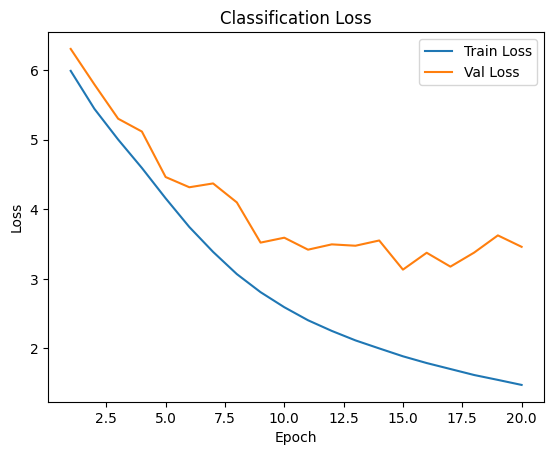

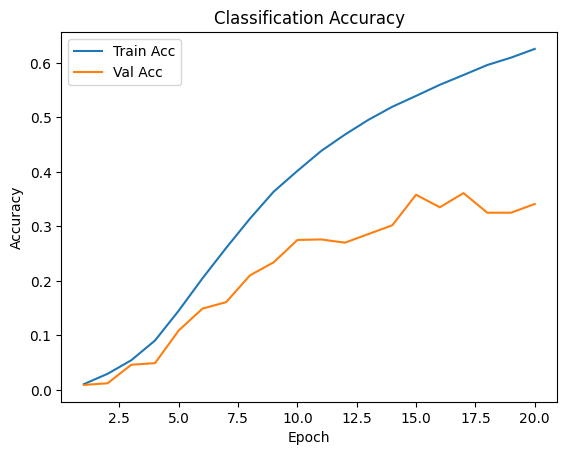

In [ ]:
# Save after classification training
torch.save(cls_model.state_dict(), supervised_model_path)

# Plot Classification Loss
epochs = range(1, params['epochs']+1)
plt.figure()
plt.plot(epochs, classify_log['train_loss'], label='Train Loss')
plt.plot(epochs, classify_log['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Classification Loss'); plt.legend(); plt.show()

# Plot Classification Accuracy
plt.figure()
plt.plot(epochs, classify_log['train_acc'], label='Train Acc')
plt.plot(epochs, classify_log['val_acc'],   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Classification Accuracy'); plt.legend(); plt.show()


## **c. Triplet Loss (Metrics Learning)**

### **Custom Dataset**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

# -------------------------------------------
# Custom Dataset that generates (anchor, positive, negative) triplets
# -------------------------------------------
class TripletDataset(Dataset):
    """
    Custom Dataset for Triplet Loss training. It samples:
        - anchor: image A
        - positive: same label as A
        - negative: different label from A
    """
    def __init__(self, ds):
        self.ds = ds
        self.label2idx = defaultdict(list)

        # Index all samples by label for quick lookup
        for idx, label in enumerate(ds.label_nums):
            self.label2idx[label].append(idx)

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        a_img, a_lbl = self.ds[idx]  # Anchor sample

        # Sample a different index with the same label (positive)
        pos = idx
        while pos == idx:
            pos = np.random.choice(self.label2idx[a_lbl])
        p_img, _ = self.ds[pos]

        # Sample a different label (negative)
        neg_lbl = a_lbl
        while neg_lbl == a_lbl:
            neg_lbl = np.random.choice(list(self.label2idx.keys()))
        neg = np.random.choice(self.label2idx[neg_lbl])
        n_img, _ = self.ds[neg]

        return a_img, p_img, n_img  # Return triplet

### **Training Loop**

In [ ]:
# Prepare Triplet dataset and DataLoader
trip_ds = TripletDataset(train_dataset)
trip_loader = DataLoader(trip_ds, batch_size=params['batch_size'], shuffle=True)

# Use the feature extractor and embedding head only (no classifier head)
trip_model = nn.Sequential(cls_model.backbone, cls_model.embed_head).to(device)

# Triplet loss components
trip_opt = optim.Adam(trip_model.parameters(), lr=1e-3)
trip_crit = nn.TripletMarginLoss(margin=1.0)
triplet_log = []

# Training loop
for ep in range(params['epochs']):
    loader = tqdm.tqdm(trip_loader, desc=f"Trip Ep{ep+1}/{params['epochs']}", leave=False)
    total = 0

    for a, p, n in loader:
        a, p, n = a.to(device), p.to(device), n.to(device)

        # Forward pass to obtain embeddings
        ea = trip_model(a)
        epos = trip_model(p)
        eneg = trip_model(n)

        # Compute Triplet Margin Loss
        loss = trip_crit(ea, epos, eneg)

        # Optimization step
        trip_opt.zero_grad()
        loss.backward()
        trip_opt.step()

        loader.set_postfix(loss=f"{loss.item():.3f}")
        total += loss.item() * a.size(0)

    # Average epoch loss
    epoch_loss = total / len(trip_loader.dataset)
    triplet_log.append(epoch_loss)

    print(f"[Triplet Epoch {ep+1}] Loss {epoch_loss:.4f}")

[Triplet Epoch 1] Loss 0.2673


[Triplet Epoch 2] Loss 0.2485


[Triplet Epoch 3] Loss 0.2368


[Triplet Epoch 4] Loss 0.2289


[Triplet Epoch 5] Loss 0.2329


[Triplet Epoch 6] Loss 0.2228


[Triplet Epoch 7] Loss 0.2201


[Triplet Epoch 8] Loss 0.2121


[Triplet Epoch 9] Loss 0.2115


[Triplet Epoch 10] Loss 0.2061


[Triplet Epoch 11] Loss 0.2081


[Triplet Epoch 12] Loss 0.2033


[Triplet Epoch 13] Loss 0.2048


[Triplet Epoch 14] Loss 0.1994


[Triplet Epoch 15] Loss 0.1982


[Triplet Epoch 16] Loss 0.1982


[Triplet Epoch 17] Loss 0.1938


[Triplet Epoch 18] Loss 0.1946


[Triplet Epoch 19] Loss 0.1910


[Triplet Epoch 20] Loss 0.1889


### **Plot**

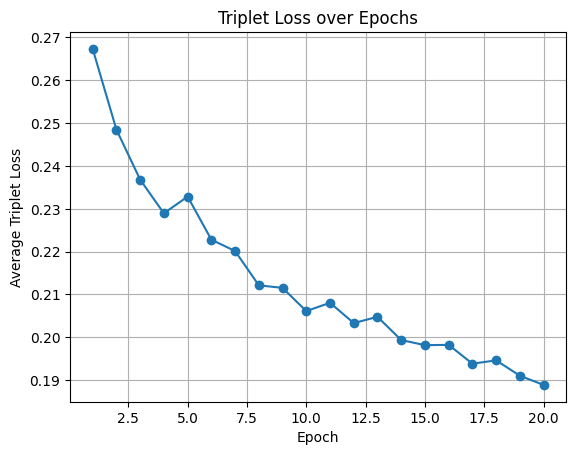

In [ ]:
torch.save(trip_model.state_dict(), triplet_model_path)

import matplotlib.pyplot as plt

epochs = list(range(1, params['epochs'] + 1))
plt.figure()
plt.plot(epochs, triplet_log, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Triplet Loss')
plt.title('Triplet Loss over Epochs')
plt.grid(True)
plt.show()

# 3. Verification ROC & AUC

## **ROC and AUC**

100%|██████████| 8805/8805 [00:13<00:00, 634.99it/s]


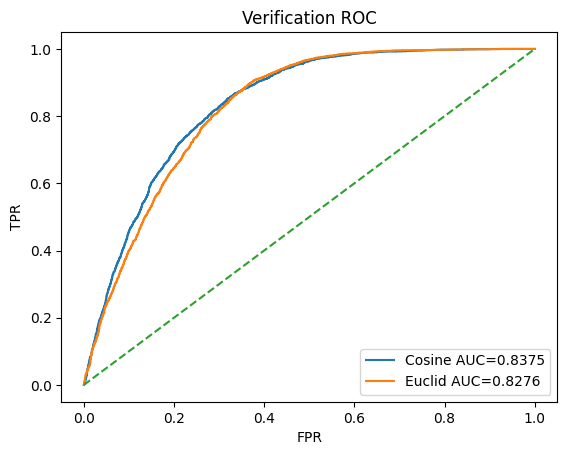

In [ ]:
# Load face verification pairs (img1, img2, label)
pairs = pd.read_csv('verification_pairs_val.txt', sep=' ', header=None, names=['img1','img2','label']).astype({'label':'int'})

# Lists to store similarity scores and ground truth labels
cosine_dist, euclidean_dist, truth_labels = [], [], []

# Loop through all image pairs and compute embeddings
for _, r in tqdm.tqdm(pairs.iterrows(), total=len(pairs)):
    def get_emb(p):
        VERIFICATION_ROOT = "/content/drive/My Drive/COS30082/Project/face_dataset"
        img_path = os.path.join(VERIFICATION_ROOT, p)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():  emb = trip_model(img)
        return emb.cpu().numpy()[0]
    e3, e4 = get_emb(r.img1), get_emb(r.img2)
    cosine_dist.append(np.dot(e3, e4)/(np.linalg.norm(e3)*np.linalg.norm(e4)))
    euclidean_dist.append(-np.linalg.norm(e3 - e4))
    truth_labels.append(r.label)

# Compute ROC and AUC for both similarity metrics
fpr_c1, tpr_c1, _ = roc_curve(truth_labels, cosine_dist)
auc_c1 = auc(fpr_c1, tpr_c1)
fpr_e1, tpr_e1, _ = roc_curve(truth_labels, euclidean_dist)
auc_e1 = auc(fpr_e1, tpr_e1)

# Plot ROC Curves
plt.figure()
plt.plot(fpr_c1, tpr_c1, label=f"Cosine AUC={auc_c1:.4f}")
plt.plot(fpr_e1, tpr_e1, label=f"Euclid AUC={auc_e1:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel('FPR'); # False Positive Rate
plt.ylabel('TPR'); # True Positive Rate
plt.title('Verification ROC'); plt.legend(); plt.show()


## **Distance Distribution**

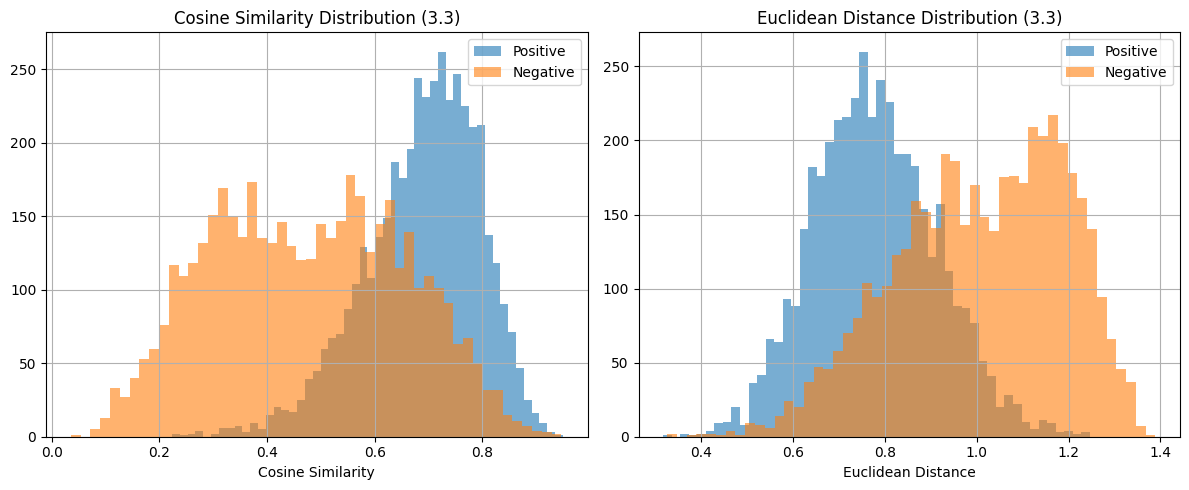

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------
# Similarity Distance Distributions
# -------------------------------
# Group cosine similarities by label (1 = positive pair, 0 = negative pair)
positive_cos = [s for s, y in zip(cosine_dist, truth_labels) if y == 1]
negative_cos = [s for s, y in zip(cosine_dist, truth_labels) if y == 0]

# Euclidean scores were negated earlier for ROC/AUC purposes → invert back
positive_euc = [-s for s, y in zip(euclidean_dist, truth_labels) if y == 1]
negative_euc = [-s for s, y in zip(euclidean_dist, truth_labels) if y == 0]

# Create side-by-side histograms
plt.figure(figsize=(12, 5))

# Plot cosine similarity distribution
plt.subplot(1, 2, 1)
plt.hist(positive_cos, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_cos, bins=50, alpha=0.6, label='Negative')
plt.title('Cosine Similarity Distribution (3.3)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Plot euclidean distance distribution
plt.subplot(1, 2, 2)
plt.hist(positive_euc, bins=50, alpha=0.6, label='Positive')
plt.hist(negative_euc, bins=50, alpha=0.6, label='Negative')
plt.title('Euclidean Distance Distribution (3.3)')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Layout and display
plt.tight_layout()
plt.show()


## **tSNE Plot**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


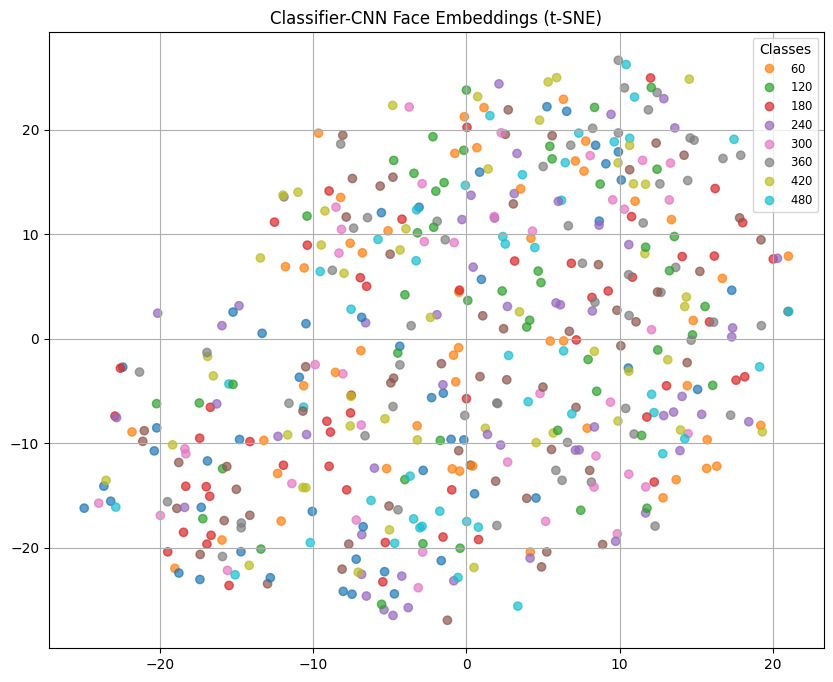

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


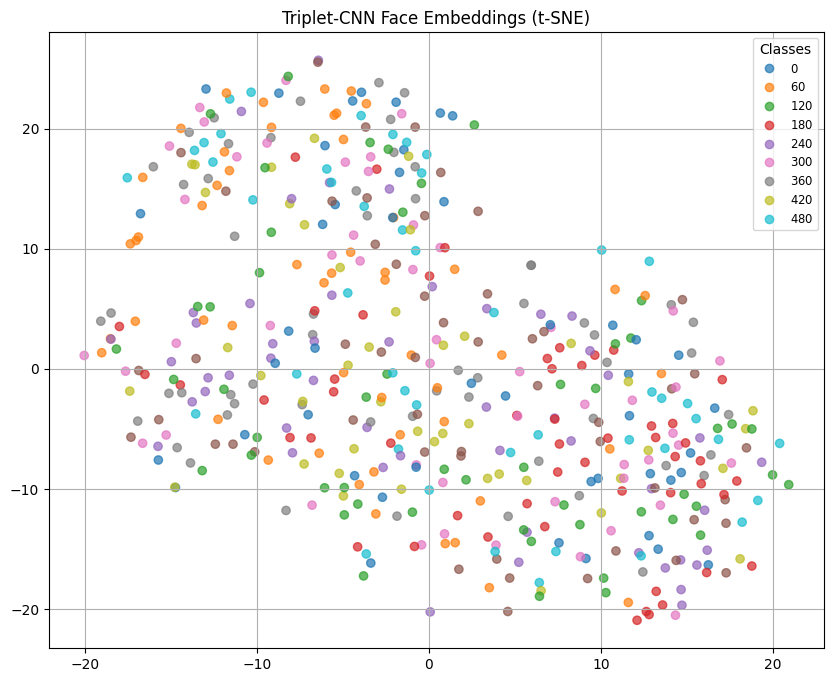

In [17]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Triplet model as Sequential
triplet_model = nn.Sequential(
    BaseCNN(),
    nn.Sequential(
        nn.Linear(128, 128),
        nn.BatchNorm1d(128)
    )
)

# ================================
# LOAD MODELS
# ================================
model_cls = Classifier(num_classes=NUM_CLASSES).to(device)
model_cls.load_state_dict(torch.load(supervised_model_path, map_location=device))
model_cls.eval()

model_triplet = triplet_model.to(device)
model_triplet.load_state_dict(torch.load(triplet_model_path, map_location=device))
model_triplet.eval()

# ================================
# EMBEDDING COLLECTION FUNCTION
# ================================

def collect_embeddings(model, dataloader, device, model_name="Model", max_samples=500):
    """
    Collects embeddings and corresponding labels from the model for visualization.
    Works with both classifier (returns tuple) and triplet (returns tensor) models.
    """
    model.eval()
    embeddings, labels = [], []
    count = 0

    for imgs, lbls in tqdm(dataloader, desc=f"[{model_name}] Collecting Embeddings", leave=False):
        imgs = imgs.to(device)

        for img, lbl in zip(imgs, lbls):
            with torch.no_grad():
                output = model(img.unsqueeze(0))
                # Handle models returning (logits, embedding)
                emb = output[1] if isinstance(output, tuple) else output
                embeddings.append(emb.squeeze().cpu().numpy())
                labels.append(lbl.item())
                count += 1
            if count >= max_samples:
                break
        if count >= max_samples:
            break

    return np.array(embeddings), np.array(labels)

# ================================
# T-SNE VISUALIZATION FUNCTION
# ================================

def plot_embeddings(embeddings, labels, title="Embeddings (t-SNE)"):
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.grid(True)
    plt.legend(*scatter.legend_elements(), title="Classes", loc="best", fontsize='small')
    plt.show()

# ================================
# RUN T-SNE FOR BOTH MODELS
# ================================

# Classifier model t-SNE
embeddings_cls, labels_cls = collect_embeddings(model_cls, val_loader, device, model_name="Classifier-CNN")
plot_embeddings(embeddings_cls, labels_cls, title="Classifier-CNN Face Embeddings (t-SNE)")

# Triplet model t-SNE
embeddings_tri, labels_tri = collect_embeddings(model_triplet, val_loader, device, model_name="Triplet-CNN")
plot_embeddings(embeddings_tri, labels_tri, title="Triplet-CNN Face Embeddings (t-SNE)")
